In [1]:
options(max.print = 100)

#default params
filtered_erna_path = "Analysis/10X_PBMC/05_erna_preprocess/filtered_erna_pbmc_granulocyte_sorted_10k.rds"
cell_type_enhancers_path = "Analysis/10X_PBMC/cell_type_enhancers/PBMC_enhancers_id.tsv"
enhancers_metadata_path = "Analysis/enhancers/tcea_super_enhancers/tcea_super_enhancers_enhancers_metadata.txt"
atac_counts_path = "Analysis/10X_PBMC/ATAC/01_count_fragments/pbmc_granulocyte_sorted_10k_enhancer_counts.mtx"
atac_barcodes_path = "Analysis/10X_PBMC/ATAC/01_count_fragments/pbmc_granulocyte_sorted_10k_barcodes.tsv"
atac_features_path = "Analysis/10X_PBMC/ATAC/01_count_fragments/pbmc_granulocyte_sorted_10k_features.tsv"
plot_correlation = FALSE
# Defaults (you can change these when running the notebook)
min_cells <- 10        # X: an enhancer must be seen in at least this many cells
min_enhancers <- 10   # X: a cell must have at least this many enhancers ATAC reads

binarize_threshold = 1



In [2]:
# Parameters
filtered_erna_path = "Analysis/10X_PBMC/05_erna_preprocess/filtered_erna_pbmc_granulocyte_sorted_10k.rds"
cell_type_enhancers_path = "Analysis/10X_PBMC/cell_type_enhancers/PBMC_enhancers_id.tsv"
enhancers_metadata_path = "Analysis/enhancers/tcea_super_enhancers/tcea_super_enhancers_enhancers_metadata.txt"
atac_counts_path = "Analysis/10X_PBMC/ATAC/01_count_fragments/pbmc_granulocyte_sorted_10k_enhancer_counts.mtx"
atac_barcodes_path = "Analysis/10X_PBMC/ATAC/01_count_fragments/pbmc_granulocyte_sorted_10k_barcodes.tsv"
atac_features_path = "Analysis/10X_PBMC/ATAC/01_count_fragments/pbmc_granulocyte_sorted_10k_features.tsv"


# eRNA count matrix analysis

In [3]:
library(magrittr)
library(dplyr)
library(stringi)
library(ggplot2)
library(Matrix)


Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [4]:
setwd(here::here()) # set working directory to project root
getwd()

[1] "/sci/labs/yotamd/lab_share/avishai.wizel/Projects/eRNA"

In [5]:
rna_enhancers = readRDS(filtered_erna_path)

# ATAC counts

In [6]:
atac_counts <- Matrix::readMM(atac_counts_path) %>% as("CsparseMatrix")

In [7]:
atac_barcodes <- read.table(atac_barcodes_path)
atac_features <- read.table(atac_features_path)
rownames(atac_counts) <- atac_features$V1
colnames(atac_counts) <- atac_barcodes$V1 %>% gsub("-1$", "", .)
atac_counts[1:10, 1:10]
dim(atac_counts)

  [[ suppressing 10 column names ‘CGTTAAATCCACCCTG’, ‘TTGCGTCTCGCCTAAG’, ‘TAGTAAGCAAGGTAAC’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                               
chr1:839908 . . . . . . 1 . . 1
chr1:839908 . . . . . . 1 . . 1
chr1:866819 . . . . . . . . . .
chr1:866819 . . . . . . . . . .
chr1:867049 . . . . . . . . . .
chr1:867049 . . . . . . . . . .
chr1:867379 . . . . . . . . . .
chr1:867379 . . . . . . . . . .
chr1:868409 . . 2 . . . . . . .
chr1:868409 . . 2 . . . . . . .

[1] 50842 11909

# ATAC normalization

In [8]:
# Filter
# keep only enhancers that expressed in at least min_cells cells
rows_to_keep = which(rowSums(atac_counts >= 1) >= min_cells)
print(length(rows_to_keep))
print( "enhancers out of " )
print(nrow(atac_counts))

# keep only cells that expressed in at least min_enhancers enhancers
cols_to_keep = which(colSums(atac_counts >= 1) >= min_enhancers)
print(length(cols_to_keep))
print( "cells out of " )
print(ncol(atac_counts))

atac_counts = atac_counts[rows_to_keep, cols_to_keep]

[1] 46070


[1] "enhancers out of "


[1] 50842


[1] 11889


[1] "cells out of "


[1] 11909


In [9]:
cell_sums_atac <- colSums(atac_counts)
# 4. Perform Library Size Normalization (Scaling)
# We divide each cell's counts by its total sum and scale to 10,000 (CP10K)

# 1. Create a diagonal matrix of the inverse of column sums
# Diagonal matrices in the Matrix package are very memory efficient
d_inv <- Diagonal(x = 1 / cell_sums_atac)

# 2. Multiply the counts by the inverse diagonal matrix
# Matrix multiplication (atac_counts %*% d_inv) will scale each column
# and return a sparse matrix (dgCMatrix)
atac_norm <- atac_counts %*% d_inv
colnames(atac_norm) <- colnames(atac_counts)
# 3. Multiply by the scaling factor (10,000)
atac_norm <- atac_norm * 10000

In [10]:
head(atac_norm)
print(summary(atac_norm@x))

  [[ suppressing 34 column names ‘CGTTAAATCCACCCTG’, ‘TTGCGTCTCGCCTAAG’, ‘TAGTAAGCAAGGTAAC’ ... ]]



  [[ suppressing 34 column names ‘CGTTAAATCCACCCTG’, ‘TTGCGTCTCGCCTAAG’, ‘TAGTAAGCAAGGTAAC’ ... ]]



  [[ suppressing 34 column names ‘CGTTAAATCCACCCTG’, ‘TTGCGTCTCGCCTAAG’, ‘TAGTAAGCAAGGTAAC’ ... ]]



6 x 11889 sparse Matrix of class "dgCMatrix"
                                                                                         
chr1:839908 . . . . . . 1.232286 . . 1.239926 . . 0.6319115 . . . . . . . . . . . . . . .
                              
chr1:839908 . . . . . . ......

 ..............................
 ........suppressing 11855 columns and 4 rows in show(); maybe adjust 'options(max.print= *, width = *)'
 ..............................
                                                                                         
chr1:867049 . . . . . . . . . . . . . . . 8.883625 . . . . 4.127115 . . . . . . . . . . .
                      
chr1:867049 . . ......

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
   0.2226    5.6022    7.2780   10.1059   11.8273 2000.0000 


# Set common enhancers and features

In [11]:
print(dim(rna_enhancers))
print(dim(atac_norm))

common_ernas = intersect(rownames(rna_enhancers), rownames(atac_norm))
print(length(common_ernas))
common_cells = intersect(colnames(rna_enhancers), colnames(atac_norm))
print(length(common_cells))

[1] 10570 11719


[1] 46070 11889


[1] 10043


[1] 11699


In [12]:
#set common rownames and colnames
rna_enhancers = rna_enhancers[common_ernas, common_cells]
atac_norm = atac_norm[common_ernas, common_cells]

In [13]:
# clear objects to save memory
rm(atac_barcodes, atac_features)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1953353,104.4,3710648,198.2,2671644,142.7
Vcells,26280474,200.6,89890630,685.9,87490183,667.5


In [14]:
class(rna_enhancers)
class(atac_counts)

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

In [15]:
head(atac_norm)
head(rna_enhancers)
class(rna_enhancers)
class(atac_norm)
dim(rna_enhancers)
dim(atac_norm)

  [[ suppressing 34 column names ‘AAACAGCCAAGGAATC’, ‘AAACAGCCAATCCCTT’, ‘AAACAGCCAATGCGCT’ ... ]]



  [[ suppressing 34 column names ‘AAACAGCCAAGGAATC’, ‘AAACAGCCAATCCCTT’, ‘AAACAGCCAATGCGCT’ ... ]]



  [[ suppressing 34 column names ‘AAACAGCCAAGGAATC’, ‘AAACAGCCAATCCCTT’, ‘AAACAGCCAATGCGCT’ ... ]]



6 x 11699 sparse Matrix of class "dgCMatrix"
                                                                                          
chr10:101688237 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......

 ..............................
 ........suppressing 11665 columns and 4 rows in show(); maybe adjust 'options(max.print= *, width = *)'
 ..............................
                                                                                          
chr10:103702315 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......

  [[ suppressing 34 column names ‘AAACAGCCAAGGAATC’, ‘AAACAGCCAATCCCTT’, ‘AAACAGCCAATGCGCT’ ... ]]



  [[ suppressing 34 column names ‘AAACAGCCAAGGAATC’, ‘AAACAGCCAATCCCTT’, ‘AAACAGCCAATGCGCT’ ... ]]



  [[ suppressing 34 column names ‘AAACAGCCAAGGAATC’, ‘AAACAGCCAATCCCTT’, ‘AAACAGCCAATGCGCT’ ... ]]



6 x 11699 sparse Matrix of class "dgCMatrix"
                                                                                          
chr10:101688237 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......

 ..............................
 ........suppressing 11665 columns and 4 rows in show(); maybe adjust 'options(max.print= *, width = *)'
 ..............................
                                                                                          
chr10:103702315 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

[1] 10043 11699

[1] 10043 11699

# Cell type specific enhancers filtering

In [16]:
# read enhancer per cell type files
library(stringi)
library(data.table)
enhancer_per_celltype_df= data.table::fread(cell_type_enhancers_path, header = F, data.table = FALSE, sep = "\t")


Attaching package: ‘data.table’




The following objects are masked from ‘package:dplyr’:

    between, first, last




In [17]:
enhancer_per_celltype = enhancer_per_celltype_df[,1]
names(enhancer_per_celltype) = enhancer_per_celltype_df[,2]
head(enhancer_per_celltype)

CD4+          CD20+           CD4+          CD20+           CD8+ 
 "chr1:839908"  "chr1:839908"  "chr1:839908"  "chr1:839908"  "chr1:866819" 
CD14+_monocyte 
 "chr1:866819"

In [18]:
cell_type_enhancers = unique(enhancer_per_celltype)
length(cell_type_enhancers)
cell_type_enhancers = intersect(cell_type_enhancers, common_ernas)
length(cell_type_enhancers)

[1] 32431

[1] 10043

In [19]:
atac_norm = (atac_norm)[cell_type_enhancers, ]
rna_enhancers  = rna_enhancers[cell_type_enhancers, ]
dim(atac_norm)
dim(rna_enhancers)

[1] 10043 11699

[1] 10043 11699

In [20]:
library(Matrix)
original_rna_mat = Matrix(rna_enhancers,sparse = TRUE)
original_atac_mat = Matrix(atac_norm,sparse = TRUE)

In [21]:
print(dim(atac_norm))
print(dim(rna_enhancers))

[1] 10043 11699


[1] 10043 11699


# Spearman correlation

In [22]:
rna_enhancers = original_rna_mat %>% as.matrix()
atac_norm = original_atac_mat %>% as.matrix() 

In [23]:
# remove all 0 cells
zero_cells = colSums(atac_norm) == 0 | colSums(rna_enhancers) == 0
atac_norm = atac_norm[, !zero_cells]
rna_enhancers = rna_enhancers[, !zero_cells]

# remove all 0 enhancers
zero_enhancers = rowSums(atac_norm) == 0 | rowSums(rna_enhancers) == 0
atac_norm = atac_norm[!zero_enhancers, ]
rna_enhancers = rna_enhancers[!zero_enhancers, ]

In [24]:
dim(atac_norm)
dim(rna_enhancers)
rna_enhancers = rna_enhancers %>% as.matrix()
atac_norm = atac_norm %>% as.matrix()
class(rna_enhancers)
class(atac_norm)

[1] 10043 11699

[1] 10043 11699

[1] "matrix" "array"

[1] "matrix" "array"

In [25]:
# spearman per cell
spearman_per_cell <- mapply(function(x, y){cor(x, y,method = "spearman")}, as.data.frame(rna_enhancers), as.data.frame(atac_norm))


In [26]:
head(spearman_per_cell)

AAACAGCCAAGGAATC AAACAGCCAATCCCTT AAACAGCCAATGCGCT AAACAGCCACACTAAT 
    0.0006911569     0.0149420497     0.0030882193    -0.0018849193 
AAACAGCCACCAACCG AAACAGCCAGGATAAC 
   -0.0070478467     0.0531253053

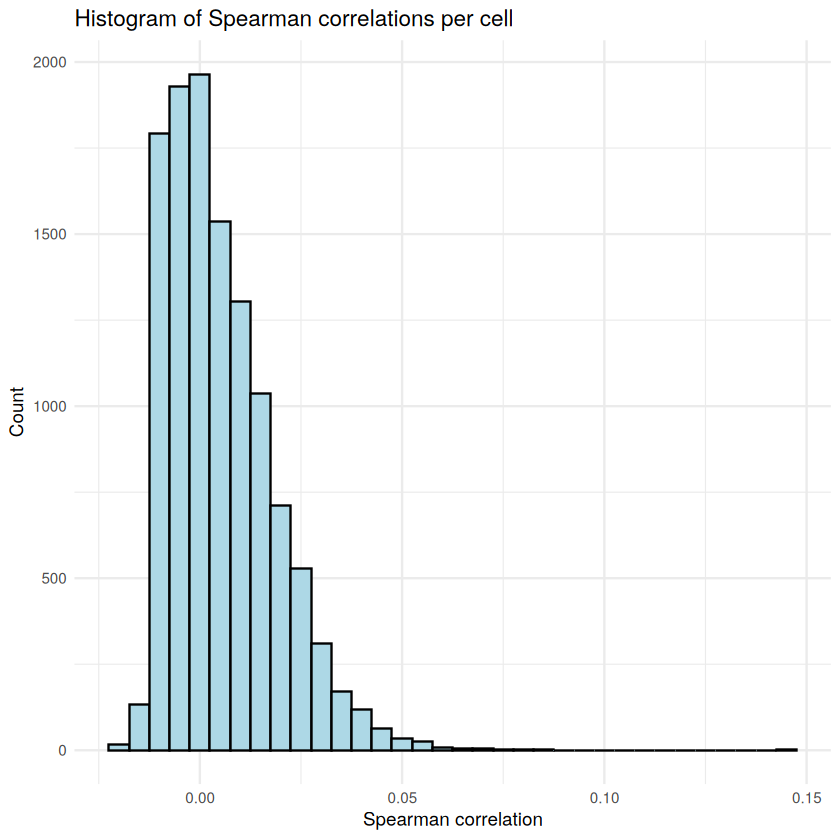

In [27]:
#histogram of spearman correlations with small binwidth
spearman_df = data.frame(spearman = spearman_per_cell)
p = ggplot(spearman_df, aes(x = spearman)) +
  geom_histogram(binwidth = 0.005, fill = "lightblue", color = "black") +
  labs(title = "Histogram of Spearman correlations per cell", x = "Spearman correlation", y = "Count") +
  theme_minimal()
p

# Cells average

In [28]:
is_open <- atac_norm > 0


cell_stats <- lapply(1:ncol(rna_enhancers), function(i) {
  open_idx <- which(is_open[, i])
    mean_open <- if(length(open_idx) > 0) mean(rna_enhancers[open_idx, i]) else 0
  
  mean_closed <- if(length(open_idx) == 0) mean(rna_enhancers[, i]) else  mean(rna_enhancers[-open_idx, i])
  
  return(data.frame(
    Cell = colnames(rna_enhancers)[i],
    Open_Score = mean_open,
    Closed_Score = mean_closed
  ))
})


In [29]:
head(cell_stats)

Cell,Open_Score,Closed_Score
<chr>,<dbl>,<dbl>
AAACAGCCAAGGAATC,0.1296232,0.09472682
Cell,Open_Score,Closed_Score
<chr>,<dbl>,<dbl>
AAACAGCCAATCCCTT,0.2006957,0.09474976
Cell,Open_Score,Closed_Score
<chr>,<dbl>,<dbl>
AAACAGCCAATGCGCT,0.1052189,0.095226
Cell,Open_Score,Closed_Score
<chr>,<dbl>,<dbl>


In [30]:

df_final <- bind_rows(cell_stats)

df_plot <- df_final %>%
  tidyr::pivot_longer(cols = c(Open_Score, Closed_Score), 
               names_to = "ATAC_status", 
               values_to = "eRNA_Expression")

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


Warning message:
“Removed 3352 rows containing non-finite outside the scale range
(`stat_ecdf()`).”


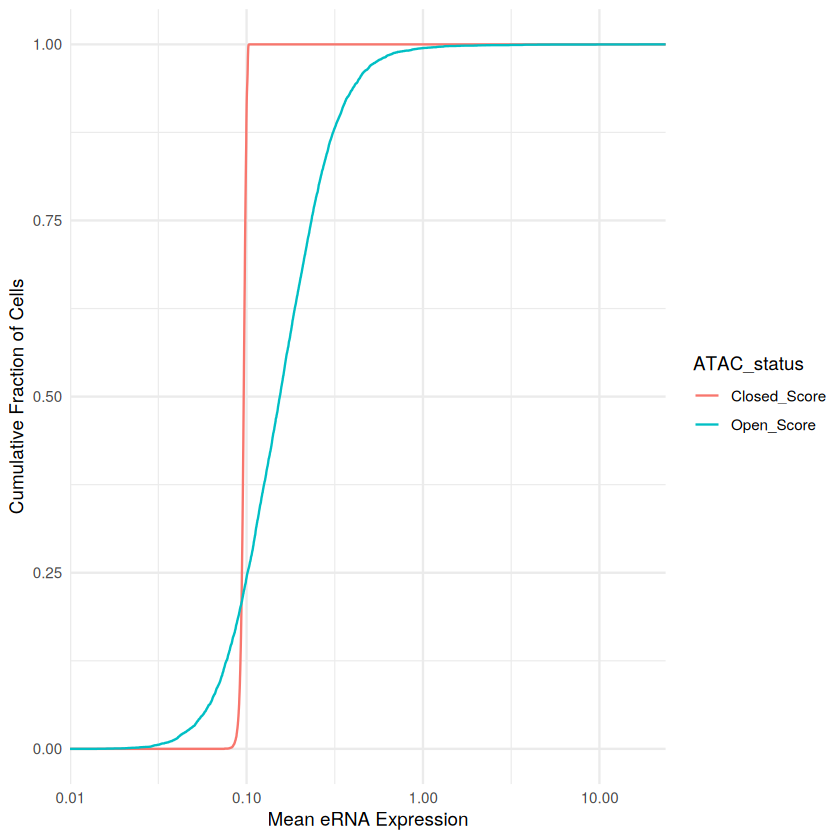

In [31]:
ggplot(df_plot, aes(x = eRNA_Expression, color = ATAC_status)) +
  stat_ecdf(geom = "step") +
  scale_x_log10() + 
  theme_minimal() +
  labs(y = "Cumulative Fraction of Cells", x = "Mean eRNA Expression")

In [32]:
ks_test <- ks.test(df_final$Open_Score, df_final$Closed_Score)
ks_test

Warning message in ks.test.default(df_final$Open_Score, df_final$Closed_Score):
“p-value will be approximate in the presence of ties”



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df_final$Open_Score and df_final$Closed_Score
D = 0.53005, p-value < 2.2e-16
alternative hypothesis: two-sided


# ATAC binary, erna continuous

In [33]:
library(Matrix)
# This creates a compact data frame
df_all <- data.frame(
  eRNA = as.vector(rna_enhancers),
  ATAC_val = as.vector(atac_norm)
)

# 4. Create the Status column efficiently
df_all$ATAC_status <- ifelse(df_all$ATAC_val > 0, "Open", "Closed")


In [34]:
aggregate(eRNA ~ ATAC_status, data = df_all, FUN = mean)

ATAC_status,eRNA
<chr>,<dbl>
Closed,0.0960496
Open,0.1371122


In [35]:
test = wilcox.test(eRNA ~ ATAC_status, data = df_all)
test


	Wilcoxon rank sum test with continuity correction

data:  eRNA by ATAC_status
W = 1.4443e+14, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


# eRNA- ATAC correlation scatter plots

In [36]:

if (plot_correlation) {
  library(ggpubr)
  library(scales)
  df = data.frame(
    eRNA = as.vector(rna_enhancers),
    ATAC = as.vector(atac_norm)
  )
  my_breaks <- c(1, 10, 100, 1000, 10000, 100000)
  my_values <- rescale(log10(my_breaks), type = "q")

  ggplot(df, aes(x = eRNA, y = ATAC)) +
    geom_bin2d(bins = 30) +
    scale_fill_gradientn(colors  = rainbow(4),values = my_values,
    breaks = my_breaks ,trans = "log10") +
    guides(fill = guide_colorbar(
      ticks.colour = "black",
      ticks.linewidth = 1,   
      frame.colour = "black",
      barheight = 15         
    ))+
    #geom_point(alpha = 0.3) +
    theme_minimal() +
    labs(title = "Global Correlation: eRNA vs ATAC Density",x = "erna", y= "ATAC")+
    geom_smooth(method = "lm", formula = y ~ x) +
    stat_cor()
}

In [37]:
enhancers_metadata <- data.table::fread(enhancers_metadata_path, header = T, sep = "\t", data.table = T)
head(enhancers_metadata)

chr,start,end,id,type,gene_intersection,bp_to_closest_gene,length
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>
1,904377,904678,chr1:839908,1,intergenic,19245,301
1,904377,904678,chr1:839908,1,intergenic,19245,301
1,905146,905447,chr1:840677,1,intergenic,18476,301
1,905176,905477,chr1:840707,1,intergenic,18446,301
1,905216,905517,chr1:840747,1,intergenic,18406,301
1,931288,931589,chr1:866819,1,intronic,0,301


In [38]:
unique(enhancers_metadata$gene_intersection)

[1] "intergenic" "intronic"

In [39]:
if (plot_correlation) {
  intergenic_enhancers = filter(enhancers_metadata, gene_intersection == "intronic")$id
  intergenic_enhancers = intersect(intergenic_enhancers, rownames(rna_enhancers))
  length(intergenic_enhancers)
  df = data.frame(
    eRNA = as.vector(rna_enhancers[intergenic_enhancers, ]),
    ATAC = as.vector(atac_norm[intergenic_enhancers, ])
  )
  dim(df)
  library(ggpubr)
  library(scales)
  my_breaks <- c(1, 10, 100, 1000, 10000, 100000)
  my_values <- rescale(log10(my_breaks), type = "q")

  ggplot(df, aes(x = eRNA, y = ATAC)) +
    geom_bin2d(bins = 30) +
    scale_fill_gradientn(colors  = rainbow(4),values = my_values,
    breaks = my_breaks ,trans = "log10") +
    guides(fill = guide_colorbar(
      ticks.colour = "black",
      ticks.linewidth = 1,   
      frame.colour = "black",
      barheight = 15         
    ))+
    #geom_point(alpha = 0.3) +
    theme_minimal() +
    labs(title = "Global Correlation: eRNA vs ATAC Density in intronic enhancers",x = "erna", y= "ATAC")+
    geom_smooth(method = "lm", formula = y ~ x) +
    stat_cor()
}

In [40]:
if (plot_correlation) {
  intergenic_enhancers = filter(enhancers_metadata, gene_intersection == "intergenic")$id
  intergenic_enhancers = intersect(intergenic_enhancers, rownames(rna_enhancers))
  length(intergenic_enhancers)
  df = data.frame(
    eRNA = as.vector(rna_enhancers[intergenic_enhancers, ]),
    ATAC = as.vector(atac_norm[intergenic_enhancers, ])
  )
  dim(df)
  library(ggpubr)
  library(scales)
  my_breaks <- c(1, 10, 100, 1000, 10000, 100000)
  my_values <- rescale(log10(my_breaks), type = "q")

  ggplot(df, aes(x = eRNA, y = ATAC)) +
    geom_bin2d(bins = 30) +
    scale_fill_gradientn(colors  = rainbow(4),values = my_values,
    breaks = my_breaks ,trans = "log10") +
    guides(fill = guide_colorbar(
      ticks.colour = "black",
      ticks.linewidth = 1,   
      frame.colour = "black",
      barheight = 15         
    ))+
    #geom_point(alpha = 0.3) +
    theme_minimal() +
    labs(title = "Global Correlation: eRNA vs ATAC Density in intergenic enhancers",x = "erna", y= "ATAC")+
    geom_smooth(method = "lm", formula = y ~ x) +
    stat_cor()
}

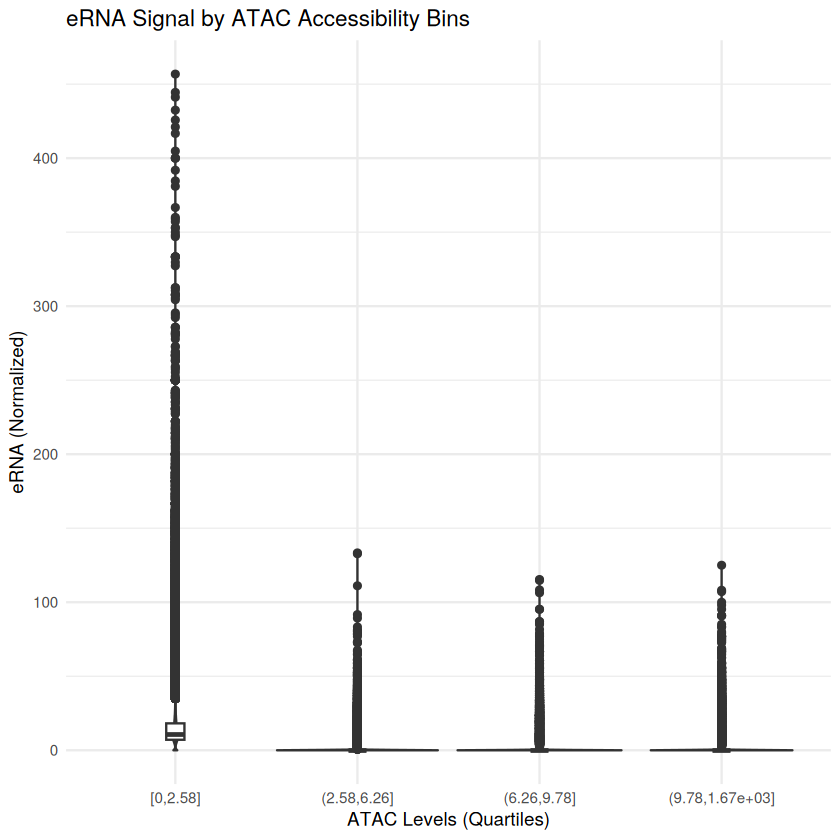

In [41]:
# Example logic for the next plot
df_corr <- data.frame(
  eRNA = as.vector(rna_enhancers),
  ATAC = as.vector(atac_norm)
)

# Filter out double zeros to see actual signal
df_corr <- df_corr[df_corr$eRNA > 0 | df_corr$ATAC > 0, ]

# Create ATAC bins
df_corr$ATAC_bin <- cut(df_corr$ATAC, breaks = quantile(df_corr$ATAC, probs = seq(0, 1, 0.25)), include.lowest = TRUE)

ggplot(df_corr, aes(x = ATAC_bin, y = eRNA)) +
  geom_violin(fill = "skyblue") +
  geom_boxplot(width = 0.1) +
  theme_minimal() +
  labs(title = "eRNA Signal by ATAC Accessibility Bins", x = "ATAC Levels (Quartiles)", y = "eRNA (Normalized)")

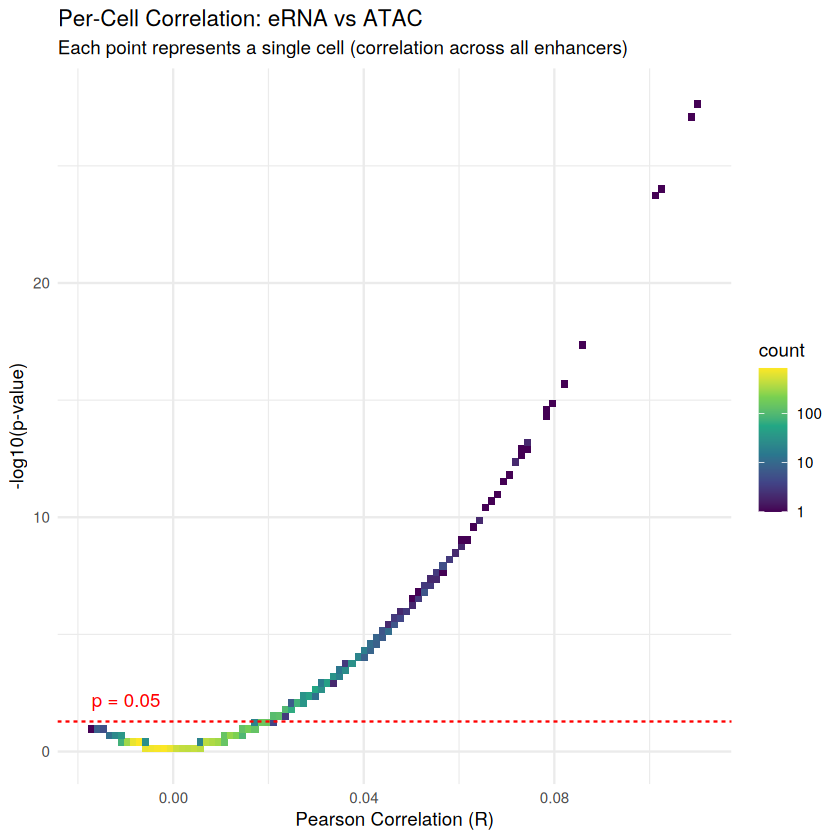

In [42]:

# 1. Calculate R and P-value for each cell (column)
# Assumption: rna_enhancers and atac_counts are matrices where 
# Rows = Enhancers and Columns = Cells.
cell_results <- sapply(1:ncol(rna_enhancers), function(i) {
  
  # Run Pearson correlation test between eRNA and ATAC for cell 'i'
  # We use use = "complete.obs" to handle potential NA values
  res <- cor.test(rna_enhancers[, i], atac_norm[, i], method = "pearson")
  
  # Return a vector containing the correlation coefficient (R) and the p-value
  return(c(R = res$estimate, pval = res$p.value))
})

# 2. Reformat the results into a Data Frame
# t() transposes the matrix so that each row represents one cell
cell_df <- as.data.frame(t(cell_results))
colnames(cell_df) <- c("R", "pvalue")

# 3. Add a column for -log10(p-value) for the Y-axis
# We add a tiny offset (1e-300) to avoid log(0) calculation for very small p-values
cell_df <- cell_df %>%
  mutate(log10p = -log10(pvalue + 1e-300))

# 4. Generate the Scatterplot
ggplot(cell_df, aes(x = R, y = log10p)) +
  # Use semi-transparent points to visualize density (useful for 5K-10K cells)
  geom_bin2d(bins = 100) +
  scale_fill_viridis_c(trans = "log10")+
  # Add a horizontal dashed line for the significance threshold (p = 0.05)
  # -log10(0.05) is approximately 1.3
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red") +
  
  # Add visual themes and labels
  theme_minimal() +
  labs(
    title = "Per-Cell Correlation: eRNA vs ATAC",
    subtitle = "Each point represents a single cell (correlation across all enhancers)",
    x = "Pearson Correlation (R)",
    y = "-log10(p-value)"
  ) +
  
  # Add a text label for the significance threshold
  annotate("text", x = min(cell_df$R), y = -log10(0.05), 
           label = "p = 0.05", color = "red", vjust = -1, hjust = 0)


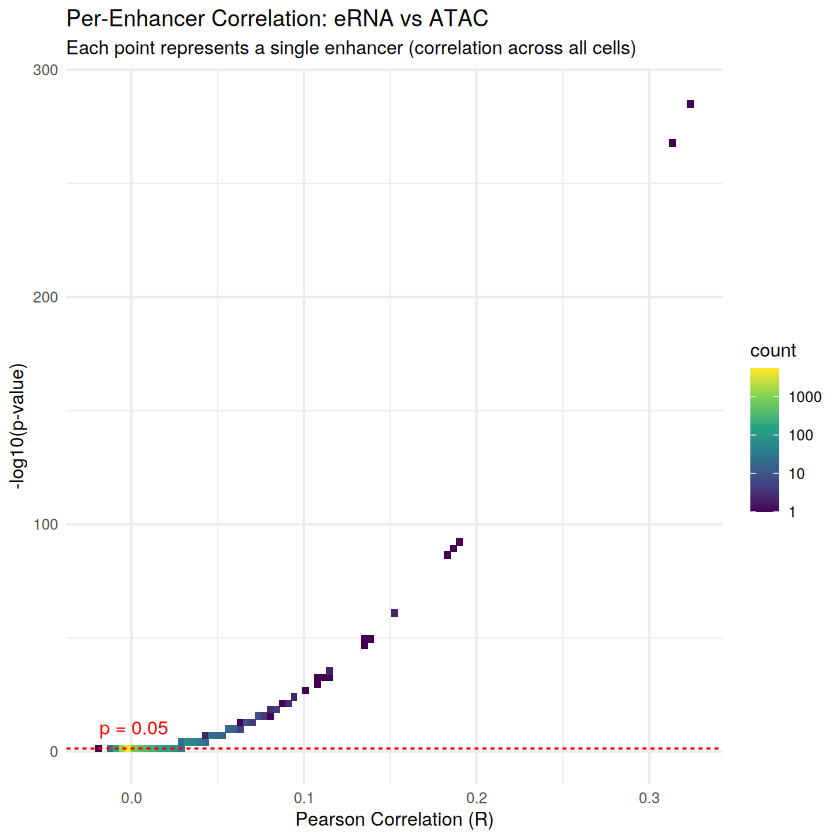

In [43]:

# 1. Calculate R and P-value for each cell (column)
cell_results <- sapply(1:nrow(rna_enhancers), function(i) {
  
  # Run Pearson correlation test between eRNA and ATAC for cell 'i'
  # We use use = "complete.obs" to handle potential NA values
  res <- cor.test(rna_enhancers[i, ], atac_norm[i, ], method = "pearson")
  
  # Return a vector containing the correlation coefficient (R) and the p-value
  return(c(R = res$estimate, pval = res$p.value))
})

# 2. Reformat the results into a Data Frame
# t() transposes the matrix so that each row represents one cell
cell_df <- as.data.frame(t(cell_results))
rownames(cell_df) <- rownames(rna_enhancers)
colnames(cell_df) <- c("R", "pvalue")

# 3. Add a column for -log10(p-value) for the Y-axis
# We add a tiny offset (1e-300) to avoid log(0) calculation for very small p-values
cell_df <- cell_df %>%
  mutate(log10p = -log10(pvalue + 1e-300))

# 4. Generate the Scatterplot
ggplot(cell_df, aes(x = R, y = log10p)) +
  # Use semi-transparent points to visualize density (useful for 5K-10K cells)
  geom_bin2d(bins = 100) +
  scale_fill_viridis_c(trans = "log10")+
  # Add a horizontal dashed line for the significance threshold (p = 0.05)
  # -log10(0.05) is approximately 1.3
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red") +
  
  # Add visual themes and labels
  theme_minimal() +
  labs(
    title = "Per-Enhancer Correlation: eRNA vs ATAC",
    subtitle = "Each point represents a single enhancer (correlation across all cells)",
    x = "Pearson Correlation (R)",
    y = "-log10(p-value)"
  ) +
  
  # Add a text label for the significance threshold
  annotate("text", x = min(cell_df$R), y = -log10(0.05), 
           label = "p = 0.05", color = "red", vjust = -1, hjust = 0)


# Binarize

In [44]:
rna_enhancers = original_rna_mat %>% as.matrix()
atac_norm = original_atac_mat %>% as.matrix() 

In [45]:
# binarize the data
atac_norm[atac_norm<binarize_threshold] <- 0
atac_norm[atac_norm>=binarize_threshold] <- 1

rna_enhancers[rna_enhancers<binarize_threshold] <- 0
rna_enhancers[rna_enhancers>=binarize_threshold] <- 1


In [46]:
# remove all 0 cells
zero_cells = colSums(atac_norm) == 0 | colSums(rna_enhancers) == 0
atac_norm = atac_norm[, !zero_cells]
rna_enhancers = rna_enhancers[, !zero_cells]

# remove all 0 enhancers
zero_enhancers = rowSums(atac_norm) == 0 | rowSums(rna_enhancers) == 0
atac_norm = atac_norm[!zero_enhancers, ]
rna_enhancers = rna_enhancers[!zero_enhancers, ]

In [47]:
print(dim(atac_norm))
dim(rna_enhancers)

[1] 10043 11699


[1] 10043 11699

In [48]:
# Jaccard Index = TP / (TP + FP + FN)
calculate_jaccard <- function(v1, v2) {
    # Check for perfect length match (safety check)
    if (length(v1) != length(v2)) stop("Vectors must be of equal length.")
    
    # True Positives (TP): Both are 1
    TP <- sum(v1 == 1 & v2 == 1)
    
    # Union Size (TP + FP + FN): At least one is 1
    union_size <- sum(v1 == 1 | v2 == 1)
    # Handle the edge case where a cell has zero activity across all 11,909 enhancers
    if (union_size == 0) return(0)  
    return(TP / union_size)
}

In [49]:
phi_per_cell <- mapply(function(x, y){cor(x, y)}, as.data.frame(rna_enhancers), as.data.frame(atac_norm))


In [50]:

head(phi_per_cell)

AAACAGCCAAGGAATC AAACAGCCAATCCCTT AAACAGCCAATGCGCT AAACAGCCACACTAAT 
     0.000796862      0.014970960      0.003051138     -0.001884921 
AAACAGCCACCAACCG AAACAGCCAGGATAAC 
    -0.007047896      0.053203761

In [51]:
jaccard_per_cell = mapply(function(x, y){calculate_jaccard(x, y)}, as.data.frame(rna_enhancers), as.data.frame(atac_norm))

In [52]:
head(jaccard_per_cell)

AAACAGCCAAGGAATC AAACAGCCAATCCCTT AAACAGCCAATGCGCT AAACAGCCACACTAAT 
     0.009508716      0.011363636      0.007194245      0.000000000 
AAACAGCCACCAACCG AAACAGCCAGGATAAC 
     0.000000000      0.026143791

In [53]:
results_df <- data.frame(
    Phi = phi_per_cell,
    Jaccard = jaccard_per_cell
)

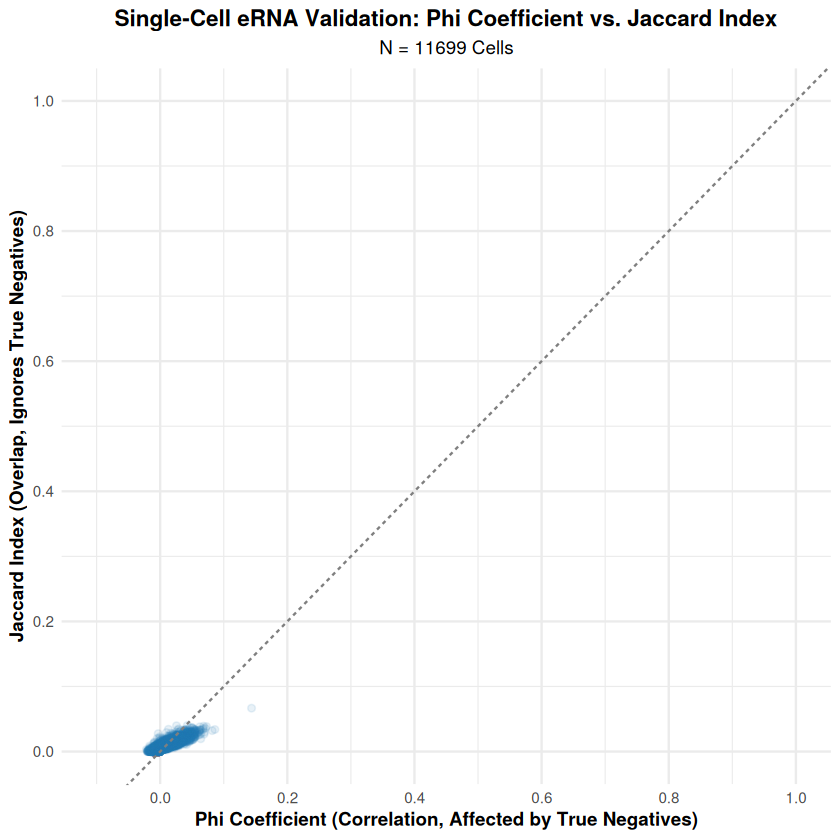

In [54]:
ggplot(results_df, aes(x = Phi, y = Jaccard)) +
    
    # 1. Scatter points with transparency (crucial for large datasets)
    # Using geom_point with high alpha to show point density.
    geom_point(alpha = 0.1, size = 1.5, color = "#1f78b4") + 
    

    
    # 3. Add the identity line (y = x) for comparison
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "gray50") +
    
    # 4. Define axis limits and labels
    scale_x_continuous(limits = c(-0.1, 1), breaks = seq(0, 1, 0.2)) + 
    scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, 0.2)) + 
    
    labs(
        title = "Single-Cell eRNA Validation: Phi Coefficient vs. Jaccard Index",
        subtitle = paste0("N = ", nrow(results_df), " Cells"),
        x = "Phi Coefficient (Correlation, Affected by True Negatives)",
        y = "Jaccard Index (Overlap, Ignores True Negatives)"
    ) +
    
    # 5. Apply a clean theme
    theme_minimal() +
    theme(
        plot.title = element_text(face = "bold", hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        axis.title = element_text(face = "bold")
    )

In [55]:

contingency_table <- table(c(as.matrix(atac_norm)),c(as.matrix(rna_enhancers)))
contingency_table

   
            0         1
  0 114242766    734013
  1   2489745     26533

In [56]:
test <- fisher.test(contingency_table)
test


	Fisher's Exact Test for Count Data

data:  contingency_table
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.638315 1.679196
sample estimates:
odds ratio 
  1.658646 


In [57]:
# histogram of fisher per cell p-values with ggplot2
library(ggplot2)
fisher_per_cell_test = function(x, y){
    fisher.test(table(x, y))$p.value
}
fisher_per_cell = mapply(fisher_per_cell_test, as.data.frame(rna_enhancers), as.data.frame(atac_norm))



[1] "Number of cells with significant association (FDR < 0.05): 47 out of 11699"


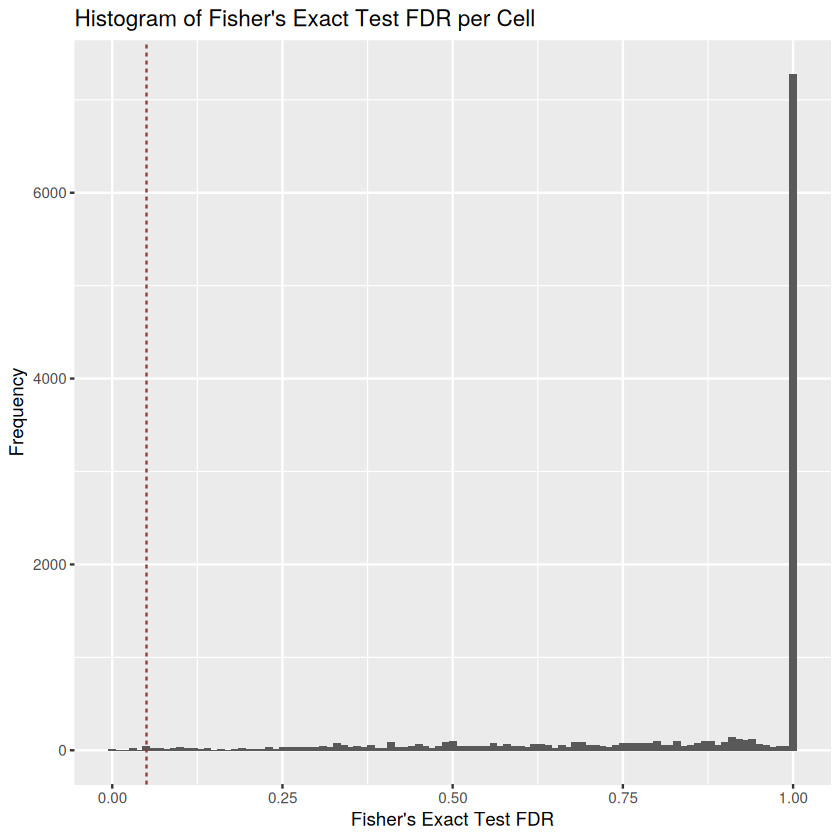

In [58]:
# create a data frame for plotting
fisher_df = data.frame(fdr = p.adjust(fisher_per_cell,method = "fdr"))

# plot the histogram
ggplot(fisher_df, aes(x = fdr)) +
    geom_histogram(binwidth = 0.01) +
    xlab("Fisher's Exact Test FDR") +
    ylab("Frequency") +
    # add line at 0.05 significance level
    geom_vline(xintercept = 0.05, color = "#8a3c3c", linetype = "dashed") +
    ggtitle("Histogram of Fisher's Exact Test FDR per Cell")

#count cells with significant FDR < 0.05
significant_cells = sum(fisher_df$fdr < 0.05)
print(paste0("Number of cells with significant association (FDR < 0.05): ", significant_cells, " out of ", length(fisher_per_cell)))

In [59]:
# histogram of fisher per enhancer p-values with ggplot2
library(ggplot2)
fisher_per_enhancer_test = function(x, y){
    tryCatch(fisher.test(table(x, y))$p.value, error = function(e) NA)
}
fisher_per_enhancer = mapply(fisher_per_enhancer_test, as.data.frame(t(rna_enhancers)), as.data.frame(t(atac_norm)))



[1] "Number of enhancers with significant association (FDR < 0.05): 135 out of 10043"


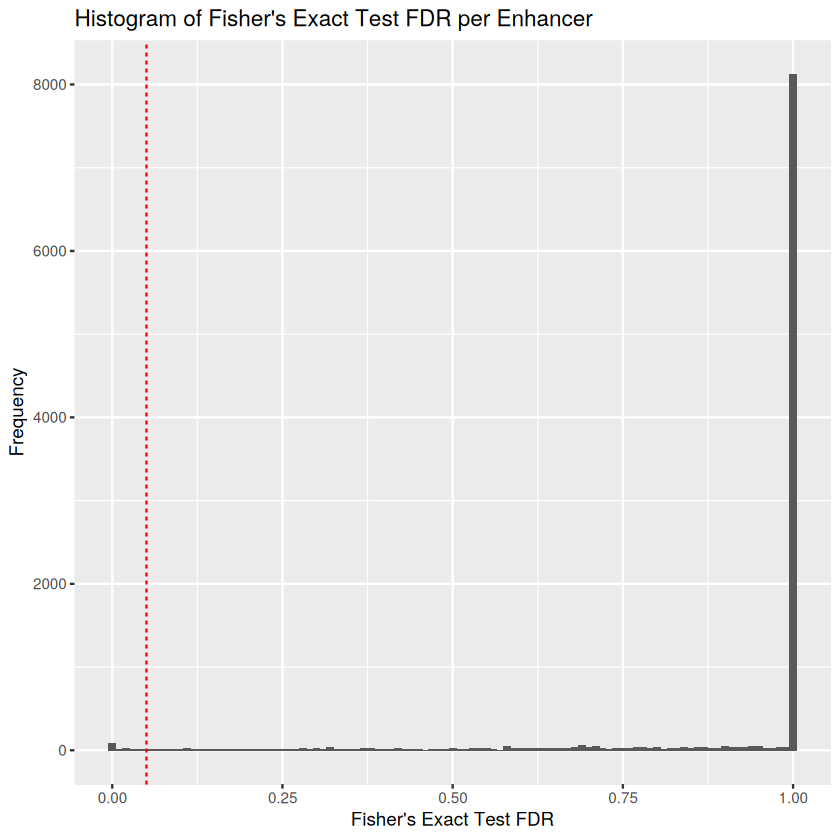

In [60]:
fisher_per_enhancer = na.omit(fisher_per_enhancer)
# create a data frame for plotting
fisher_df = data.frame(fdr = p.adjust(fisher_per_enhancer,method = "fdr"))

# plot the histogram
ggplot(fisher_df, aes(x = fdr)) +
    geom_histogram(binwidth = 0.01) +
    xlab("Fisher's Exact Test FDR") +
    ylab("Frequency") +
    # add line at 0.05 significance level
    geom_vline(xintercept = 0.05, color = "red", linetype = "dashed") +
    ggtitle("Histogram of Fisher's Exact Test FDR per Enhancer")

#count enhancers with significant FDR < 0.05
significant_enhancers = sum(fisher_df$fdr < 0.05)
print(paste0("Number of enhancers with significant association (FDR < 0.05): ", significant_enhancers, " out of ", length(fisher_per_enhancer)))